# Overview:

The following notebook to complete a project for the University of Michigan Coursera course "Applied Machine Learning in Python". It seeks to identify a machine learning model that can predict videos that will retain large amounts of their viewers.

The data used was takend from the VLE Dataset put together by researcher Sahan Bulathwela at University College London. The target variable is `engagement` which was defined as True if the median percentage of the video watched across all viewers was at least 30%, and False otherwise. 

# About the data:

**Data fields**

train.csv & test.csv:

    title_word_count - the number of words in the title of the video.
    
    document_entropy - a score indicating how varied the topics are covered in the video, based on the transcript. Videos with smaller entropy scores will tend to be more cohesive and more focused on a single topic.
    
    freshness - The number of days elapsed between 01/01/1970 and the lecture published date. Videos that are more recent will have higher freshness values.
    
    easiness - A text difficulty measure applied to the transcript. A lower score indicates more complex language used by the presenter.
    
    fraction_stopword_presence - A stopword is a very common word like 'the' or 'and'. This feature computes the fraction of all words that are stopwords in the video lecture transcript.
    
    speaker_speed - The average speaking rate in words per minute of the presenter in the video.
    
    silent_period_rate - The fraction of time in the lecture video that is silence (no speaking).
    
train.csv only:
    
    engagement - Target label for training. True if learners watched a substantial portion of the video (see description), or False otherwise.

# Import Libraries and Data:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

# Import various models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import plot_tree

In [3]:
# Import Training Data:
train=pd.read_csv('assets/train.csv')

# Set the features that will be used for predictions:
feature_names = ['title_word_count', 'document_entropy', 'freshness', 'easiness',
       'fraction_stopword_presence', 'normalization_rate', 'speaker_speed',
       'silent_period_rate']
X = train[feature_names]
y = train['engagement']

# Perform a split on the data to evaluate generated models:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Functions:

In [18]:
"""

The first function I will define will evaluate different machine learning models. I will use the default model parameters to
get a quick sense what model can best handle this particular dataset.
"""

def evaluate_models(X, y, cv=5):
    """
    Evaluate multiple models using cross-validation and return performance metrics.
    
    Parameters:
    X : features DataFrame
    y : target Series (binary)
    cv : number of cross-validation folds
    """
    # I will test the key models that were included in the machine learning course.
    models = {
        'Logistic Regression': LogisticRegression(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'SVM': SVC(random_state=42, probability=True),
        'KNN': KNeighborsClassifier()
    }
    
    # Dictionary to store results
    results = {}
    
    # Logistic Regression, SVMs and KNNs require data to be scaled consistently accross features. I will apply a built in scaler to the data. 
    for name, model in models.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])
        
        # Cross-validation splits the data several times and generates a mean value accross the different splits to provide more reliable model selections
        cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')
        
        results[name] = {
            'mean_score': cv_scores.mean(),
            'std_score': cv_scores.std(),
            'pipeline': pipeline
        }
        
        print(f"{name}:")
        # print the ROC-AUC scores from the Cross-validation split
        print(f"Mean ROC-AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
        print()
    
    return results

In [20]:
"""

With the best model identify I will now perform hyperparameter tuning on the model to optimize it.
"""

def tune_best_model(X, y, best_model_name, results):

    # Define parameter grids for each model type. These will provide the model with a couple different test parameters to see what performs the best.
    param_grids = {
        'Logistic Regression': {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
            # L1 is Lasso, L2 is ridge
            'classifier__penalty': ['l1', 'l2'],
            'classifier__solver': ['liblinear', 'saga']
        },
        'Random Forest': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [None, 10, 20, 30],
            'classifier__min_samples_split': [2, 5, 10]
        },
        'Gradient Boosting': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__learning_rate': [0.01, 0.1, 0.3],
            'classifier__max_depth': [3, 4, 5]
        },
        'SVM': {
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['rbf', 'linear'],
            'classifier__gamma': ['scale', 'auto', 0.1, 0.01]
        },
        'KNN': {
            'classifier__n_neighbors': [3, 5, 7, 9, 11],
            'classifier__weights': ['uniform', 'distance'],
            'classifier__metric': ['euclidean', 'manhattan']
        }
    }
    
    # Get the pipeline and parameter grid for the best model
    best_pipeline = results[best_model_name]['pipeline']
    param_grid = param_grids[best_model_name]
    
    # Perform grid search
    grid_search = GridSearchCV(
        best_pipeline,
        param_grid,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )
    
    grid_search.fit(X, y)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score:", grid_search.best_score_)
    
    return grid_search.best_estimator_

In [22]:
"""
Tree-based models can easily provide a feature importance analysis. This can help steer 
business decisions on how to optimize videos for retention. What aspects of the video should 
we tweek in future uploads to improve retention? Where would our efforts produce the best improvements?
"""
def analyze_feature_importance(model, feature_names):

    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        print("\nFeature Ranking:")
        for f in range(len(feature_names)):
            print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

# Run functions on training data:

In [24]:
# Step 1: Evaluate all models
results = evaluate_models(X_train, y_train)

# Step 2: Find the best model name based on mean score
best_model_name = max(results.items(), key=lambda x: x[1]['mean_score'])[0]
print(f"\nBest model: {best_model_name}")

# Step 3: Tune the best model
tuned_model = tune_best_model(X_train, y_train, best_model_name, results)

# Step 4: Make predictions with the tuned model
y_pred = tuned_model.predict(X_test)

# Step 5: Print final evaluation metrics
print("\nFinal Model Performance:")
print(classification_report(y_test, y_pred))

# Step 6: If it's a tree-based model, analyze feature importance
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    analyze_feature_importance(tuned_model.named_steps['classifier'], feature_names)

Logistic Regression:
Mean ROC-AUC: 0.845 (+/- 0.029)

Random Forest:
Mean ROC-AUC: 0.888 (+/- 0.023)

Gradient Boosting:
Mean ROC-AUC: 0.883 (+/- 0.021)

SVM:
Mean ROC-AUC: 0.838 (+/- 0.028)

KNN:
Mean ROC-AUC: 0.803 (+/- 0.033)


Best model: Random Forest
Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best cross-validation score: 0.891192008572449

Final Model Performance:
              precision    recall  f1-score   support

       False       0.95      0.98      0.96      1683
        True       0.68      0.47      0.56       165

    accuracy                           0.93      1848
   macro avg       0.82      0.73      0.76      1848
weighted avg       0.93      0.93      0.93      1848


Feature Ranking:
1. document_entropy (0.361872)
2. freshness (0.132378)
3. easiness (0.115207)
4. fraction_stopword_presence (0.111801)
5. speaker_speed (0.098083)
6. normalization_rate (0.076307)
7. silent_period_rate (0.0665

# Applying model to a new dataset with no target label:

In [20]:
# Import new data
new=pd.read_csv('assets/test.csv')

X_new = new[feature_names]

# Get probability predictions
probabilities = tuned_model.predict_proba(X_new)[:, 1]

# Create a series with video IDs as index and probabilities as values
engagement_predictions = pd.Series(
    data=probabilities,
    index=new['id'],  # Replace 'object_id' with your actual ID column name
    name='engagement_probability'
)

# Print first few predictions
print(engagement_predictions.head())

id
9240    0.020140
9241    0.040920
9242    0.125056
9243    0.785147
9244    0.029827
Name: engagement_probability, dtype: float64


# General Visualizations

I will define a function to produce a couple visualizations to understand engagement and feature importance, I will make this general and model agnostic.

In [81]:
# Set some general plotting parameters for better visibility
plt.rcParams['figure.figsize'] = [15, 12]
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 10

def create_visualization_suite(predictions, feature_values, true_labels=None, figsize=(15, 12)):
    """
    Create a comprehensive visualization suite for engagement predictions
    
    Parameters:
    predictions: Series of prediction probabilities with video IDs as index
    feature_values: DataFrame of feature values used for predictions
    true_labels: Optional Series of true engagement values for validation data
    figsize: Tuple for figure size
    """
    fig = plt.figure(figsize=figsize)
    
    # Create grid layout
    gs = plt.GridSpec(3, 2, figure=fig)
    
    # 1. Probability Distribution (Histogram)
    ax1 = fig.add_subplot(gs[0, :])
    sns.histplot(predictions, bins=30, ax=ax1)
    ax1.set_title('Distribution of Engagement Probabilities')
    ax1.set_xlabel('Probability of High Engagement')
    ax1.set_ylabel('Count')
    
    # 3. Feature Correlation Heatmap
    ax3 = fig.add_subplot(gs[1, :])
    correlation_matrix = feature_values.corr()
    sns.heatmap(correlation_matrix, 
                annot=True, 
                cmap='coolwarm', 
                center=0,
                ax=ax3)
    ax3.set_title('Feature Correlation Heatmap')
    
    # 4. Probability Threshold Analysis (if true labels are provided)
    if true_labels is not None:
        ax4 = fig.add_subplot(gs[2, 0])
        thresholds = np.linspace(0, 1, 100)
        accuracies = []
        for threshold in thresholds:
            predicted_labels = (predictions > threshold).astype(int)
            accuracy = (predicted_labels == true_labels).mean()
            accuracies.append(accuracy)
        
        ax4.plot(thresholds, accuracies)
        ax4.set_title('Accuracy vs Probability Threshold')
        ax4.set_xlabel('Probability Threshold')
        ax4.set_ylabel('Accuracy')
        ax4.grid(True)
        
        # 5. Confusion Matrix at 0.5 threshold
        ax5 = fig.add_subplot(gs[2, 1])
        predicted_labels = (predictions > 0.5).astype(int)
        conf_matrix = pd.crosstab(true_labels, predicted_labels, 
                                 margins=True, margins_name='Total')
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax5)
        ax5.set_title('Confusion Matrix (0.5 threshold)')
    else:
        # 4. Alternative: Engagement Probability Range Distribution
        ax4 = fig.add_subplot(gs[2, 0])
        ranges = pd.cut(predictions, bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
        range_counts = ranges.value_counts()
        sns.barplot(x=range_counts.index, y=range_counts.values, ax=ax4)
        ax4.set_title('Distribution of Engagement Levels')
        ax4.set_ylabel('Count')
        ax4.tick_params(axis='x', rotation=45)
        
        # 5. Feature Importance (if model has feature_importances_)
        ax5 = fig.add_subplot(gs[2, 1])
        if hasattr(tuned_model.named_steps['classifier'], 'feature_importances_'):
            importances = pd.Series(
                tuned_model.named_steps['classifier'].feature_importances_,
                index=feature_values.columns
            ).sort_values(ascending=True)
            
            sns.barplot(x=importances.values, y=importances.index, ax=ax5)
            ax5.set_title('Feature Importance')
            ax5.set_xlabel('Importance Score')
    
    plt.tight_layout()
    return fig

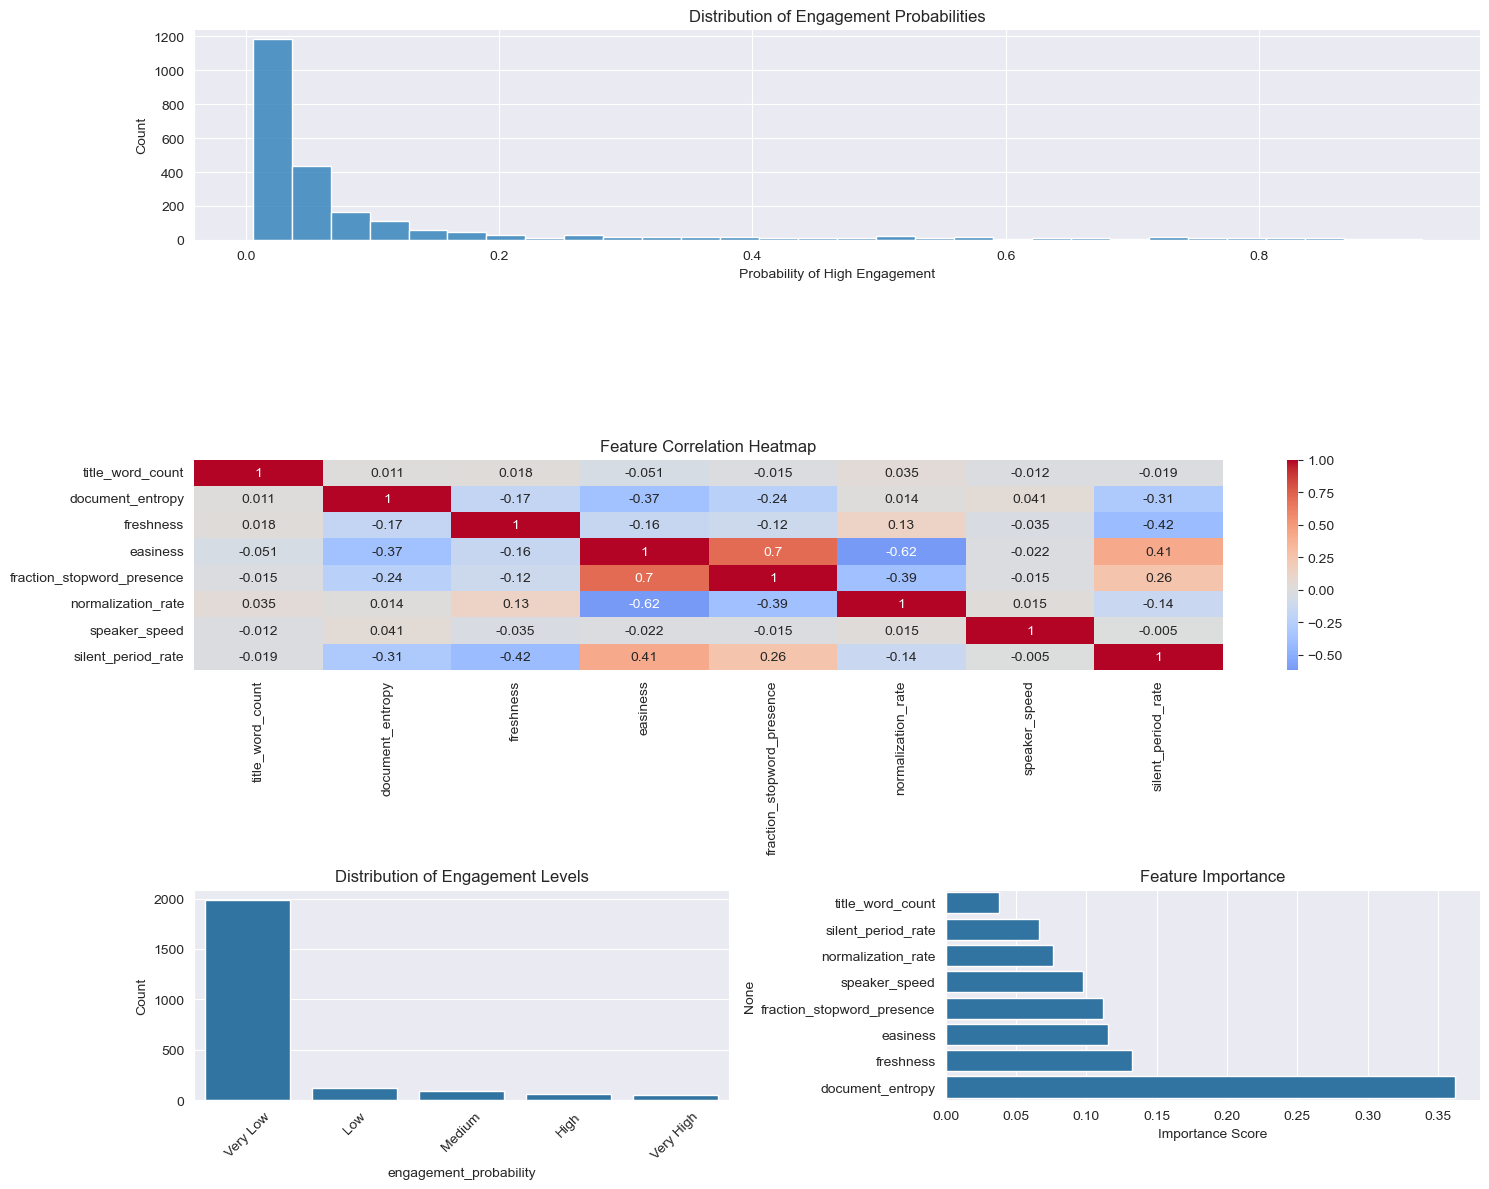

In [83]:
fig = create_visualization_suite(engagement_predictions, X_new)
plt.show()

# Random Forest Plots:

The data was best predicted by a random forest model, I will create some figures specifically tailored for the model.

In [94]:
def plot_feature_importance_detailed(model, feature_names, figsize=(12, 6), save_path=None):
    """
    Create a detailed feature importance plot with error bars based on individual trees
    """
    plt.figure(figsize=figsize)
    
    # Get feature importance from each tree
    importances = []
    for tree in model.named_steps['classifier'].estimators_:
        importances.append(tree.feature_importances_)
    
    # Calculate mean and std of importance
    importances = np.array(importances)
    importance_mean = importances.mean(axis=0)
    importance_std = importances.std(axis=0)
    
    # Create DataFrame for plotting
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_mean,
        'std': importance_std
    }).sort_values('importance', ascending=True)
    
    # Plot
    plt.barh(importance_df['feature'], 
            importance_df['importance'],
            xerr=importance_std,
            alpha=0.8,
            capsize=5)
    
    plt.title('Feature Importance with Variance Across Trees')
    plt.xlabel('Importance Score')
    plt.grid(True, axis='x')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='jpg')
    
    return plt.gcf()

def plot_tree_visualization(model, feature_names, figsize=(20, 10), save_path=None):
    """
    Visualize the first tree in the forest
    """
    plt.figure(figsize=figsize)
    
    # Get the first tree from the forest
    tree_to_plot = model.named_steps['classifier'].estimators_[0]
    
    # Plot the tree
    plot_tree(tree_to_plot, 
             feature_names=feature_names,
             filled=True,
             rounded=True,
             max_depth=3,  # Limit depth for visibility
             fontsize=10)
    
    plt.title('Visualization of First Tree in Random Forest (Limited to Depth 3)')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='jpg')
    
    return plt.gcf()

def plot_prediction_confidence(predictions, bins=20, figsize=(12, 6), save_path=None):
    """
    Analyze prediction confidence distribution
    """
    plt.figure(figsize=figsize)
    
    # Calculate confidence scores (distance from 0.5)
    confidence_scores = abs(predictions - 0.5) * 2
    
    # Create the plot
    plt.hist(confidence_scores, bins=bins, edgecolor='black')
    plt.axvline(confidence_scores.mean(), color='red', linestyle='dashed', 
                label=f'Mean Confidence: {confidence_scores.mean():.2f}')
    
    plt.title('Distribution of Prediction Confidence')
    plt.xlabel('Confidence Score (0 = Uncertain, 1 = Very Confident)')
    plt.ylabel('Number of Predictions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='jpg')
    
    return plt.gcf()

def plot_feature_pair_decision_boundaries(model, X, feature1, feature2, predictions, 
                                        num_points=100, figsize=(12, 6), save_path=None):
    """
    Plot decision boundaries for a pair of features
    """
    plt.figure(figsize=figsize)
    
    # Create mesh grid
    x1_min, x1_max = X[feature1].min(), X[feature1].max()
    x2_min, x2_max = X[feature2].min(), X[feature2].max()
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, num_points),
                          np.linspace(x2_min, x2_max, num_points))
    
    # Create feature matrix for predictions
    X_plot = pd.DataFrame({
        feature1: xx1.ravel(),
        feature2: xx2.ravel()
    })
    
    # Add zero columns for other features
    for col in X.columns:
        if col not in [feature1, feature2]:
            X_plot[col] = 0
    
    # Get predictions for mesh
    X_plot = X_plot[X.columns]  # Ensure same column order as training data
    Z = model.predict_proba(X_plot)[:, 1]
    Z = Z.reshape(xx1.shape)
    
    # Plot decision boundary
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap='RdYlBu')
    plt.colorbar(label='Probability of High Engagement')
    
    # Plot actual data points
    scatter = plt.scatter(X[feature1], X[feature2], 
                         c=predictions, 
                         cmap='RdYlBu',
                         edgecolor='black',
                         alpha=0.6)
    
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title(f'Decision Boundaries for {feature1} vs {feature2}')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='jpg')
    
    return plt.gcf()

def plot_rf_analysis_suite(model, X, predictions, feature_names, save_path=None):
    """
    Create a comprehensive suite of Random Forest specific visualizations
    """
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 15))
    gs = plt.GridSpec(2, 2, figure=fig)
    
    # 1. Feature Importance
    ax1 = fig.add_subplot(gs[0, 0])
    importances = pd.Series(
        model.named_steps['classifier'].feature_importances_,
        index=feature_names
    ).sort_values(ascending=True)
    sns.barplot(x=importances.values, y=importances.index, ax=ax1)
    ax1.set_title('Feature Importance')
    ax1.set_xlabel('Importance Score')
    
    # 2. Prediction Confidence Distribution
    ax2 = fig.add_subplot(gs[0, 1])
    confidence_scores = abs(predictions - 0.5) * 2
    sns.histplot(confidence_scores, bins=20, ax=ax2)
    ax2.axvline(confidence_scores.mean(), color='red', linestyle='dashed',
                label=f'Mean: {confidence_scores.mean():.2f}')
    ax2.set_title('Prediction Confidence Distribution')
    ax2.set_xlabel('Confidence Score')
    ax2.legend()
    
    # 3. Decision Tree Visualization (first tree)
    ax3 = fig.add_subplot(gs[1, :])
    tree_to_plot = model.named_steps['classifier'].estimators_[0]
    plot_tree(tree_to_plot, 
             feature_names=feature_names,
             filled=True,
             rounded=True,
             max_depth=2,  # Limited depth for visibility
             ax=ax3)
    ax3.set_title('First Tree Visualization (Limited to Depth 2)')
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, format='jpg')
    
    return fig

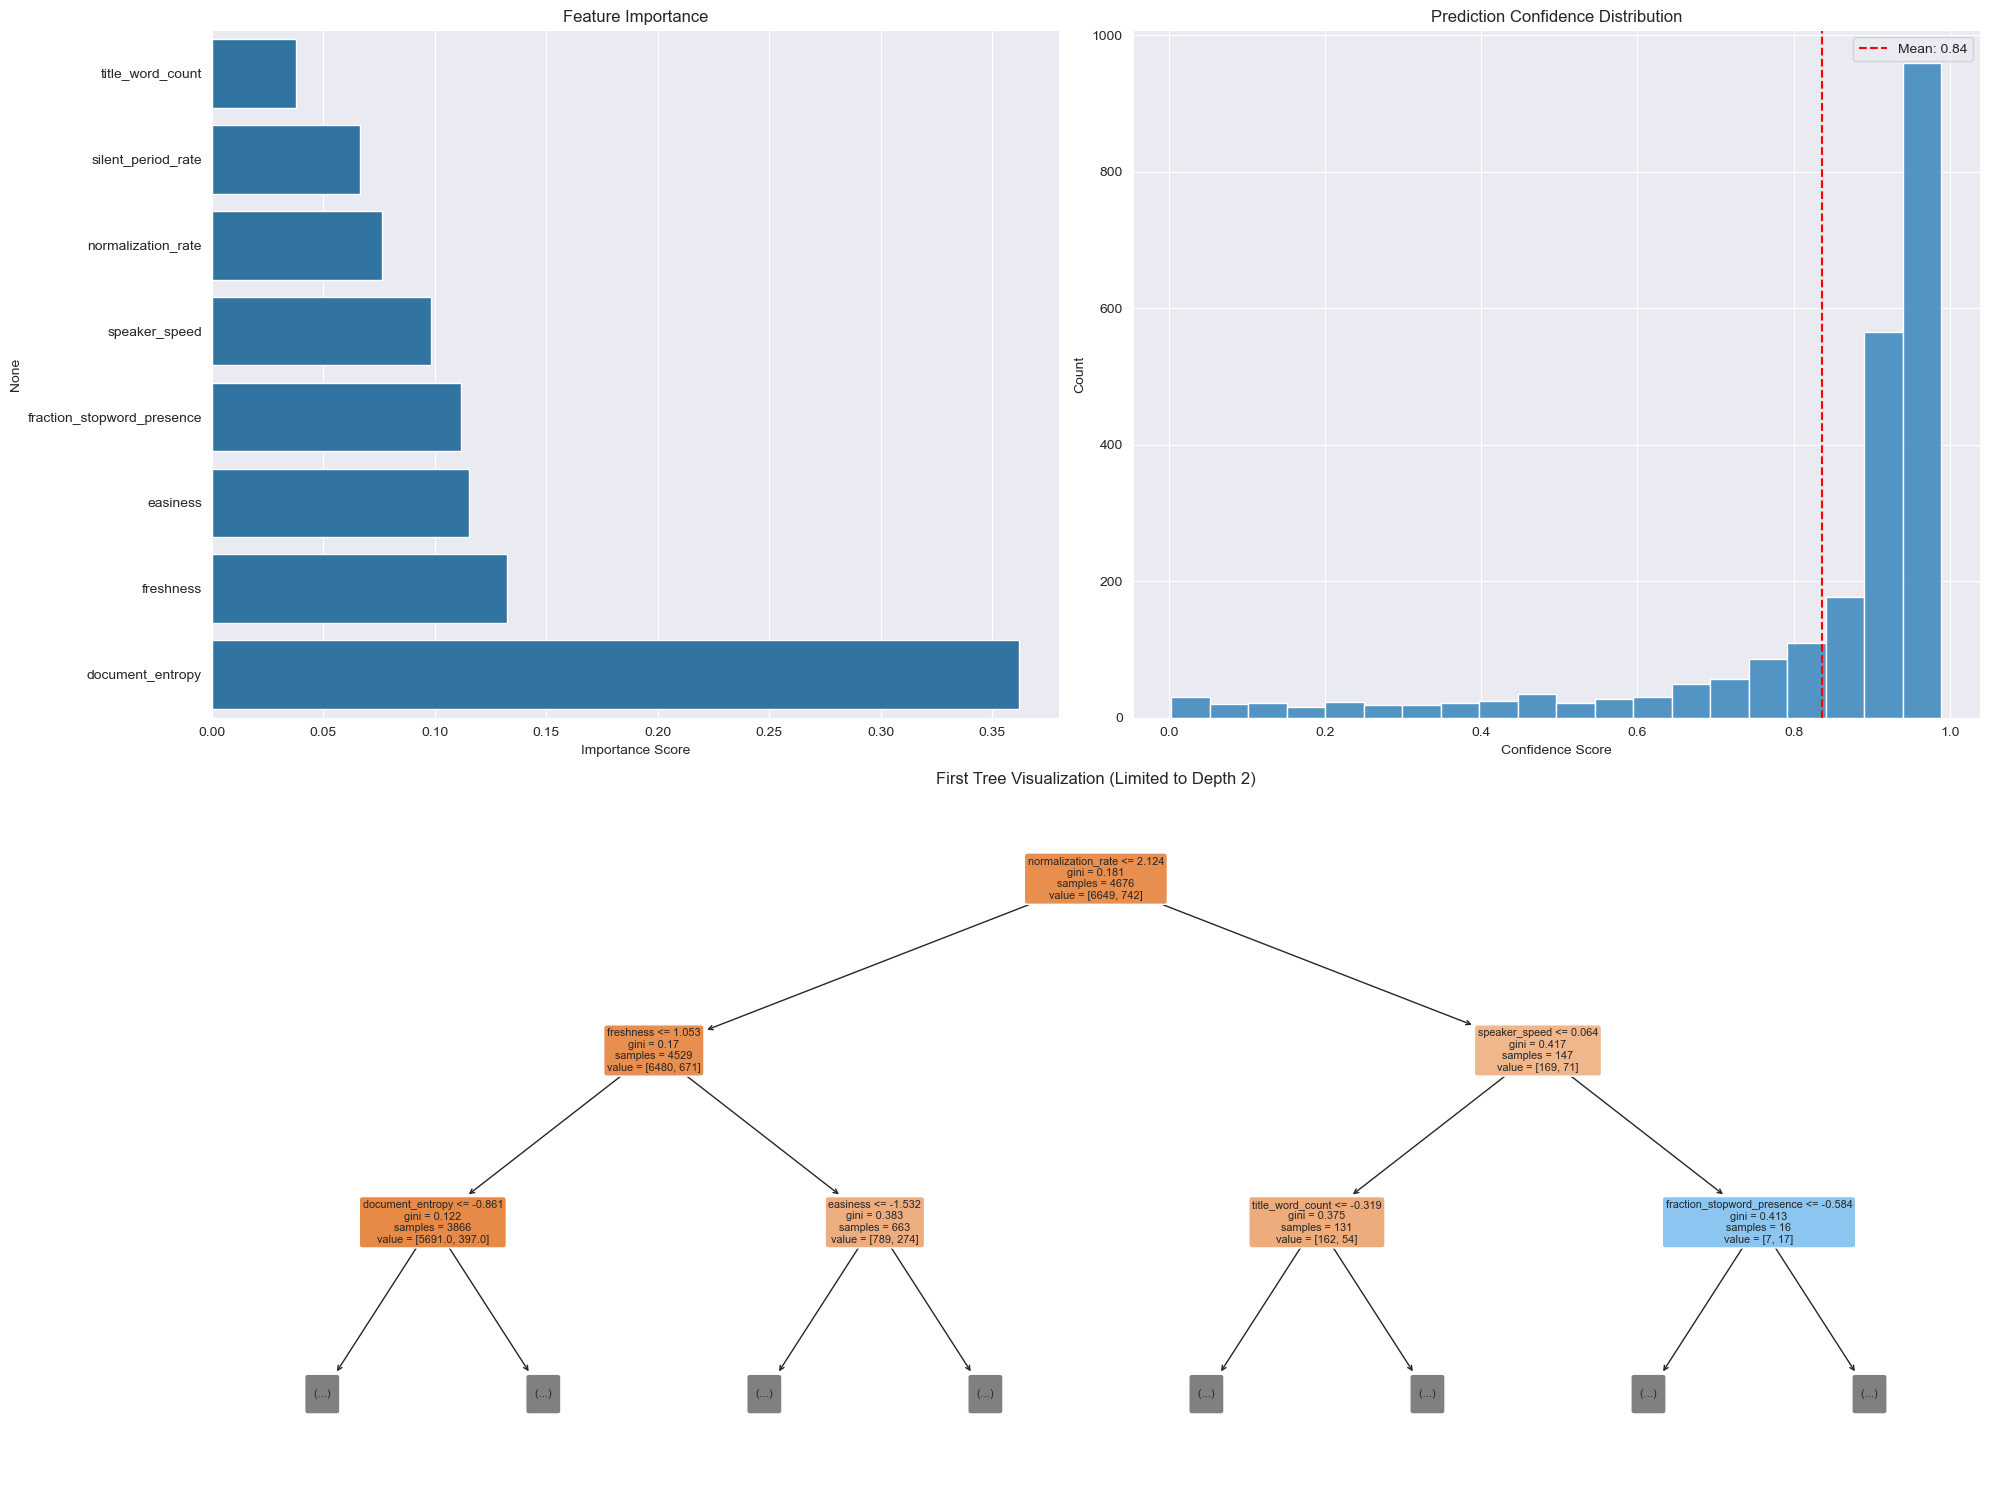

In [102]:
# Call the graphing function:
fig = plot_rf_analysis_suite(tuned_model, X_new, engagement_predictions, feature_names)


## Example where the export of the image is enabled:
#fig = plot_rf_analysis_suite(tuned_model, X_new, engagement_predictions, feature_names, 'test.jpg')

plt.show()